In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.1.9 --progress-bar off
!pip install -qqq langgraph==0.2.4 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-text-splitters 0.3.9 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 0.2.43 which is incompatible.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 0.2.43 which is incompatible.


In [7]:
import os
import sqlite3
import numpy as np
import pickle
from dataclasses import dataclass
from datetime import date, timedelta
from enum import Enum, auto
from typing import Annotated, List, Literal, Optional, Set, TypedDict, Dict, Tuple
from collections import defaultdict

from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from google.colab import userdata

In [42]:
# Configuration
MODEL = "llama3-8b-8192"
DB_NAME = "habit_tracker.db"
RL_AGENTS_DIR = "rl_agents"

In [43]:
# Create directory for RL agents if it doesn't exist
os.makedirs(RL_AGENTS_DIR, exist_ok=True)

# Initialize LLM (you'll need to set your API key)
llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("lama3"))

class DayOfWeek(Enum):
    MONDAY = auto()
    TUESDAY = auto()
    WEDNESDAY = auto()
    THURSDAY = auto()
    FRIDAY = auto()
    SATURDAY = auto()
    SUNDAY = auto()

In [44]:
@dataclass
class Habit:
    id: int
    name: str
    repeat_frequency: Set[DayOfWeek]
    tags: List[str]

@dataclass
class DailyHabitEntry:
    id: int
    name: str
    tags: List[str]
    is_completed: bool

In [45]:
# ===== REINFORCEMENT LEARNING AGENT =====

class HabitRLAgent:
    """Reinforcement Learning Agent for habit recommendations and optimization"""

    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.completion_history = []
        self.action_history = []
        self.reward_history = []

    def get_state(self, user_habits: List[Habit], current_date: date) -> str:
        """Create state representation from current habits and date"""
        weekday = current_date.weekday()
        active_habits = len([h for h in user_habits if DayOfWeek(weekday + 1) in h.repeat_frequency])
        completion_rate = self._calculate_recent_completion_rate()
        streak = self._calculate_current_streak()

        # Create discrete state buckets
        rate_bucket = int(completion_rate * 10)  # 0-10
        streak_bucket = min(streak // 3, 5)  # 0-5 (groups of 3 days)
        habits_bucket = min(active_habits, 10)  # cap at 10

        return f"day_{weekday}_habits_{habits_bucket}_rate_{rate_bucket}_streak_{streak_bucket}"

    def get_action(self, state: str, available_actions: List[str]) -> str:
        """Choose action using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)

        q_values = [self.q_table[state][action] for action in available_actions]
        if not q_values or max(q_values) == min(q_values):
            return np.random.choice(available_actions)

        return available_actions[np.argmax(q_values)]

    def update_q_table(self, state: str, action: str, reward: float, next_state: str, available_next_actions: List[str]):
        """Update Q-table using Q-learning"""
        current_q = self.q_table[state][action]
        max_next_q = max([self.q_table[next_state][a] for a in available_next_actions], default=0)

        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state][action] = new_q

        # Store for analysis
        self.action_history.append((state, action))
        self.reward_history.append(reward)

    def calculate_reward(self, action: str, completion_result: bool, streak_length: int, habit_difficulty: str = "medium") -> float:
        """Calculate reward based on completion and streaks"""
        base_reward = 10 if completion_result else -5
        streak_bonus = min(streak_length * 2, 20)  # Cap bonus at 20

        # Action-specific rewards
        action_rewards = {
            "recommend_easy_habit": 5 if completion_result else -2,
            "recommend_challenging_habit": 15 if completion_result else -8,
            "encourage_existing": streak_bonus if completion_result else -3,
            "suggest_rest_day": 8 if not completion_result else -5,  # Rest days are good when not completing
            "complete_habit": base_reward + streak_bonus
        }

        action_reward = action_rewards.get(action, 0)

        # Difficulty multiplier
        difficulty_multipliers = {"easy": 0.8, "medium": 1.0, "hard": 1.3}
        multiplier = difficulty_multipliers.get(habit_difficulty, 1.0)

        total_reward = (base_reward + action_reward) * multiplier
        return total_reward

    def _calculate_recent_completion_rate(self) -> float:
        """Calculate completion rate for last 7 days"""
        if len(self.completion_history) < 1:
            return 0.5  # Default rate
        recent = self.completion_history[-7:] if len(self.completion_history) >= 7 else self.completion_history
        return sum(recent) / len(recent)

    def _calculate_current_streak(self) -> int:
        """Calculate current completion streak"""
        if not self.completion_history:
            return 0

        streak = 0
        for completion in reversed(self.completion_history):
            if completion:
                streak += 1
            else:
                break
        return streak

    def get_performance_stats(self) -> Dict:
        """Get agent performance statistics"""
        return {
            "total_actions": len(self.action_history),
            "avg_reward": np.mean(self.reward_history) if self.reward_history else 0,
            "completion_rate": self._calculate_recent_completion_rate(),
            "current_streak": self._calculate_current_streak(),
            "q_table_size": len(self.q_table)
        }

In [46]:
# ===== DATABASE FUNCTIONS =====

def get_connection():
    return sqlite3.connect(DB_NAME)

def create_tables():
    """Create all necessary database tables"""
    with get_connection() as conn:
        cursor = conn.cursor()

        # Original tables
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS habits (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT NOT NULL,
                repeat_frequency TEXT NOT NULL,
                tags TEXT NOT NULL,
                difficulty TEXT DEFAULT 'medium'
            )
        """)

        cursor.execute("""
            CREATE TABLE IF NOT EXISTS completions (
                habit_id INTEGER,
                completion_date TEXT,
                PRIMARY KEY (habit_id, completion_date),
                FOREIGN KEY (habit_id) REFERENCES habits (id)
            )
        """)

        # RL-specific tables
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS rl_states (
                user_id TEXT,
                state TEXT,
                action TEXT,
                reward REAL,
                timestamp TEXT,
                PRIMARY KEY (user_id, timestamp)
            )
        """)

        cursor.execute("""
            CREATE TABLE IF NOT EXISTS user_preferences (
                user_id TEXT PRIMARY KEY,
                preferred_difficulty REAL DEFAULT 0.5,
                motivation_type TEXT DEFAULT 'streak',
                best_completion_time TEXT DEFAULT 'morning',
                rl_epsilon REAL DEFAULT 0.1
            )
        """)

        conn.commit()

def list_habits() -> List[Habit]:
    """Get all habits from database"""
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT id, name, repeat_frequency, tags FROM habits")
        return [
            Habit(
                id,
                name,
                {DayOfWeek[day] for day in freq.split(",") if day},
                tags.split(",") if tags else [],
            )
            for id, name, freq, tags in cursor.fetchall()
        ]

def habits_for_date(target_date: date) -> List[DailyHabitEntry]:
    """Get habits scheduled for a specific date"""
    weekday = DayOfWeek(target_date.weekday() + 1).name
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT h.id, h.name, h.tags, c.completion_date IS NOT NULL as completed
            FROM habits h
            LEFT JOIN completions c ON h.id = c.habit_id AND c.completion_date = ?
            WHERE instr(h.repeat_frequency, ?) > 0
        """, (target_date.isoformat(), weekday))

        return [
            DailyHabitEntry(id, name, tags.split(",") if tags else [], bool(completed))
            for id, name, tags, completed in cursor.fetchall()
        ]

def complete_habit(habit_id: int, completion_date: date):
    """Mark a habit as completed for a specific date"""
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            INSERT OR REPLACE INTO completions (habit_id, completion_date)
            VALUES (?, ?)
        """, (habit_id, completion_date.isoformat()))
        conn.commit()

def add_habit(name: str, repeat_frequency: Set[DayOfWeek], tags: List[str] = [], difficulty: str = "medium") -> int:
    """Add a new habit to the database"""
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            INSERT INTO habits (name, repeat_frequency, tags, difficulty)
            VALUES (?, ?, ?, ?)
        """, (
            name,
            ",".join(day.name for day in repeat_frequency),
            ",".join(tags),
            difficulty
        ))
        conn.commit()
        return cursor.lastrowid

def calculate_habit_streak(habit_id: int, end_date: date) -> int:
    """Calculate the current streak for a specific habit"""
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT completion_date FROM completions
            WHERE habit_id = ? AND completion_date <= ?
            ORDER BY completion_date DESC
        """, (habit_id, end_date.isoformat()))

        completions = [date.fromisoformat(row[0]) for row in cursor.fetchall()]

        if not completions:
            return 0

        streak = 0
        current_date = end_date

        for completion_date in completions:
            if completion_date == current_date:
                streak += 1
                current_date -= timedelta(days=1)
            elif completion_date == current_date:
                continue
            else:
                break

        return streak

def get_habit_completion_rate(habit_id: int, days: int = 30) -> float:
    """Get completion rate for a habit over the last N days"""
    end_date = date.today()
    start_date = end_date - timedelta(days=days)

    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT COUNT(*) FROM completions
            WHERE habit_id = ? AND completion_date BETWEEN ? AND ?
        """, (habit_id, start_date.isoformat(), end_date.isoformat()))

        completions = cursor.fetchone()[0]
        return completions / days if days > 0 else 0

In [47]:
# ===== RL AGENT MANAGEMENT =====

def save_rl_agent(user_id: str, agent: HabitRLAgent):
    """Save RL agent to disk"""
    agent_path = os.path.join(RL_AGENTS_DIR, f"{user_id}_agent.pkl")
    with open(agent_path, 'wb') as f:
        pickle.dump(agent, f)

def load_or_create_rl_agent(user_id: str) -> HabitRLAgent:
    """Load existing RL agent or create new one"""
    agent_path = os.path.join(RL_AGENTS_DIR, f"{user_id}_agent.pkl")

    if os.path.exists(agent_path):
        try:
            with open(agent_path, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Error loading agent: {e}, creating new one")

    return HabitRLAgent()

In [48]:
# ===== ENHANCED TOOLS WITH RL =====

class CompleteHabitParams(BaseModel):
    habit_id: int = Field(description="Id (number) of the habit e.g. 2")
    day: int = Field(description="Day of the month (1-31) e.g. 18")
    month: int = Field(description="Month of the year (1-12) e.g. 3")
    year: int = Field(description="Year for which to complete the habit e.g. 2024")

@tool(args_schema=CompleteHabitParams)
def complete_habit_tool(habit_id: int, day: int, month: int, year: int):
    """Completes a habit for a specific date and updates RL agent"""
    completion_date = date(year, month, day)
    complete_habit(habit_id, completion_date)

    # Update RL agent
    user_id = "default_user"  # In real app, get from context
    agent = load_or_create_rl_agent(user_id)

    # Calculate reward
    streak = calculate_habit_streak(habit_id, completion_date)
    reward = agent.calculate_reward("complete_habit", True, streak)

    # Update agent state
    habits = list_habits()
    state = agent.get_state(habits, completion_date)
    next_date = completion_date + timedelta(days=1)
    next_state = agent.get_state(habits, next_date)

    agent.update_q_table(state, "complete_habit", reward, next_state, ["complete_habit"])
    agent.completion_history.append(1)

    save_rl_agent(user_id, agent)

    return f"Habit {habit_id} completed for {completion_date}. Streak: {streak} days!"

class HabitsForDateParams(BaseModel):
    day: int = Field(description="Day of the month (1-31) e.g. 18")
    month: int = Field(description="Month of the year (1-12) e.g. 3")
    year: int = Field(description="Year for which to get habits e.g. 2024")

@tool(args_schema=HabitsForDateParams)
def habits_for_date_tool(day: int, month: int, year: int):
    """Returns a list of habits for a given date"""
    return habits_for_date(date(year, month, day))

class AddHabitParams(BaseModel):
    name: str = Field(description="Name of the habit")
    repeat_frequency: Set[DayOfWeek] = Field(description="Which days of the week the habit should repeat")
    tags: Optional[List[str]] = Field(description="Optional list of tags for this habit")
    difficulty: Optional[str] = Field(description="Difficulty level: easy, medium, or hard")

@tool(args_schema=AddHabitParams)
def add_habit_tool(name: str, repeat_frequency: Set[DayOfWeek], tags: List[str] = [], difficulty: str = "medium") -> int:
    """Adds a new habit with specific repeat frequency. Returns the ID of the habit."""
    return add_habit(name, repeat_frequency, tags, difficulty)

class RLRecommendationParams(BaseModel):
    user_id: str = Field(description="User identifier", default="default_user")
    current_date: Optional[str] = Field(description="Current date in YYYY-MM-DD format")

@tool(args_schema=RLRecommendationParams)
def get_rl_habit_recommendation(user_id: str = "default_user", current_date: str = None):
    """Get personalized habit recommendation using RL agent"""
    if current_date is None:
        current_date = date.today().isoformat()

    agent = load_or_create_rl_agent(user_id)
    habits = list_habits()
    date_obj = date.fromisoformat(current_date)

    state = agent.get_state(habits, date_obj)
    actions = [
        "recommend_easy_habit",
        "recommend_challenging_habit",
        "encourage_existing",
        "suggest_rest_day"
    ]

    action = agent.get_action(state, actions)

    recommendations = {
        "recommend_easy_habit": "🌱 Consider adding a simple 5-minute habit like drinking water, deep breathing, or writing one sentence in a journal.",
        "recommend_challenging_habit": "🚀 You're doing great! Ready for a challenge? Try a 30-minute workout, reading 20 pages, or learning something new.",
        "encourage_existing": "⭐ Focus on completing your existing habits today to maintain your amazing streak! Consistency is key.",
        "suggest_rest_day": "🛌 Take it easy today - rest and recovery are important. Light activities only. Tomorrow you'll be refreshed!"
    }

    recommendation = recommendations.get(action, "Keep up the great work with your habits!")

    # Store or update this recommendation for learning
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            INSERT OR REPLACE INTO rl_states (user_id, state, action, reward, timestamp)
            VALUES (?, ?, ?, ?, ?)
        """, (user_id, state, action, 0, current_date))  # Reward will be updated later
        conn.commit()

    return f"{recommendation}\\n\\nCurrent stats: {agent.get_performance_stats()}"

class HabitStatsParams(BaseModel):
    habit_id: Optional[int] = Field(description="Specific habit ID to get stats for")
    days: Optional[int] = Field(description="Number of days to look back", default=30)

@tool(args_schema=HabitStatsParams)
def get_habit_statistics(habit_id: int = None, days: int = 30):
    """Get detailed statistics for habits"""
    if habit_id:
        habits_to_analyze = [h for h in list_habits() if h.id == habit_id]
    else:
        habits_to_analyze = list_habits()

    stats = []
    for habit in habits_to_analyze:
        completion_rate = get_habit_completion_rate(habit.id, days)
        current_streak = calculate_habit_streak(habit.id, date.today())

        stats.append({
            "id": habit.id,
            "name": habit.name,
            "completion_rate": f"{completion_rate:.1%}",
            "current_streak": f"{current_streak} days",
            "tags": habit.tags
        })

    return stats

class UserStatsParams(BaseModel):
    user_id: str = Field(description="User identifier", default="default_user")

@tool(args_schema=UserStatsParams)
def get_user_rl_stats(user_id: str = "default_user"):
    """Get RL agent performance statistics for user"""
    agent = load_or_create_rl_agent(user_id)
    return agent.get_performance_stats()

In [49]:
# ===== LANGGRAPH SETUP =====

# Collect all tools
tools = [
    complete_habit_tool,
    habits_for_date_tool,
    add_habit_tool,
    get_rl_habit_recommendation,
    get_habit_statistics,
    get_user_rl_stats
]

# Enhanced state with RL capabilities
class EnhancedAppState(TypedDict):
    messages: Annotated[list, add_messages]
    habits: List[Habit]
    rl_recommendations: List[str]
    user_id: str

# System template with RL context
SYSTEM_TEMPLATE = PromptTemplate.from_template("""
You are an AI habit tracking assistant with advanced reinforcement learning capabilities.

Current habits in the system:
{habits}

Recent RL recommendations:
{rl_recommendations}

You can help users:
1. Track and complete habits
2. Add new habits with difficulty levels
3. Get personalized recommendations based on their behavior patterns
4. View detailed statistics and analytics
5. Receive motivation based on their completion patterns

The RL system learns from user behavior to provide increasingly personalized recommendations.
Always be encouraging and focus on building sustainable habits.
""")

def update_habits(state: EnhancedAppState):
    """Update habits and RL recommendations in state"""
    user_id = state.get("user_id", "default_user")
    current_date = date.today().isoformat()

    # Get fresh habits list
    habits = list_habits()

    # Get RL recommendation
    try:
        recommendation = get_rl_habit_recommendation(user_id, current_date)
        rl_recommendations = [recommendation]
    except Exception as e:
        rl_recommendations = ["RL system initializing..."]

    return {
        "habits": habits,
        "rl_recommendations": rl_recommendations,
        "user_id": user_id
    }

def call_model(state: EnhancedAppState):
    """Call the language model with enhanced context"""
    messages = state["messages"]
    habits = state.get("habits", [])
    rl_recommendations = state.get("rl_recommendations", [])

    system_message = SystemMessage(
        SYSTEM_TEMPLATE.format(
            habits=habits,
            rl_recommendations="\\n".join(rl_recommendations)
        )
    )

    # Replace or insert system message
    if messages and messages[0].type == "system":
        messages[0] = system_message
    else:
        messages.insert(0, system_message)

    # Note: You'll need to uncomment and configure your LLM
    response = llm.invoke(messages)
    return {"messages": [response]}

    # Placeholder response for demo
    # return {"messages": [HumanMessage(content="LLM not configured. Please add your API key and uncomment llm initialization.")]}

# Create tool node
tool_node = ToolNode(tools)

def should_continue(state: EnhancedAppState) -> Literal["tools", END]:
    """Determine if we should continue to tools or end"""
    messages = state["messages"]
    last_message = messages[-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    return END

In [50]:
# Build the graph
def create_enhanced_habit_graph():
    """Create the enhanced habit tracking graph with RL"""
    graph = StateGraph(EnhancedAppState)

    # Add nodes
    graph.add_node("update_habits", update_habits)
    graph.add_node("agent", call_model)
    graph.add_node("tools", tool_node)

    # Add edges
    graph.add_edge("update_habits", "agent")
    graph.add_conditional_edges("agent", should_continue)
    graph.add_edge("tools", "update_habits")

    # Set entry point
    graph.set_entry_point("update_habits")

    return graph



In [51]:
def show_habits_for_date(target_date: date):
    """Display habits for a specific date"""
    print(f"\\nHabits for {target_date}:")
    entries = habits_for_date(target_date)

    if not entries:
        print("No habits scheduled for this date.")
        return

    for entry in entries:
        status = "✅ Completed" if entry.is_completed else "⏳ Not completed"
        print(f"  {entry.name} (ID: {entry.id}): {status}")
        if entry.tags:
            print(f"    Tags: {', '.join(entry.tags)}")

def initialize_sample_data():
    """Initialize the system with sample data"""
    print("Initializing database and sample data...")
    create_tables()

    # Add sample habits
    gym_id = add_habit(
        "Hit the gym",
        {DayOfWeek.MONDAY, DayOfWeek.WEDNESDAY, DayOfWeek.FRIDAY},
        ["exercise", "fitness"],
        "hard"
    )

    reading_id = add_habit(
        "Read for 30 minutes",
        {DayOfWeek.MONDAY, DayOfWeek.TUESDAY, DayOfWeek.WEDNESDAY, DayOfWeek.THURSDAY, DayOfWeek.FRIDAY},
        ["learning", "reading"],
        "medium"
    )

    water_id = add_habit(
        "Drink 8 glasses of water",
        set(DayOfWeek),  # Every day
        ["health", "hydration"],
        "easy"
    )

    print(f"Created sample habits with IDs: {gym_id}, {reading_id}, {water_id}")
    return gym_id, reading_id, water_id

def demo_rl_system():
    """Demonstrate the RL system capabilities"""
    print("\\n=== RL SYSTEM DEMO ===")

    # Initialize sample data
    gym_id, reading_id, water_id = initialize_sample_data()

    # Show today's habits
    today = date.today()
    show_habits_for_date(today)

    # Get RL recommendation
    print("\\n=== RL Recommendation ===")
    # Call the tool using invoke and provide an empty dict as input since parameters are optional
    recommendation = get_rl_habit_recommendation.invoke({})
    print(recommendation)

    # Complete a habit and show updated recommendation
    print("\\n=== Completing a habit ===")
    complete_habit(water_id, today)
    show_habits_for_date(today)

    # Get updated recommendation
    print("\\n=== Updated RL Recommendation ===")
    # Call the tool using invoke and provide an empty dict as input since parameters are optional
    updated_recommendation = get_rl_habit_recommendation.invoke({})
    print(updated_recommendation)

    # Show statistics
    print("\\n=== Statistics ===")
    # Call the tool using invoke and provide an empty dict as input since parameters are optional
    stats = get_habit_statistics.invoke({})
    for stat in stats:
        print(f"{stat['name']}: {stat['completion_rate']} completion rate, {stat['current_streak']} streak")

In [52]:
graph.nodes

{'update_habits': StateNodeSpec(runnable=update_habits(recurse=True), metadata=None, input=<class '__main__.EnhancedAppState'>, retry_policy=None),
 'agent': StateNodeSpec(runnable=agent(recurse=True), metadata=None, input=<class '__main__.EnhancedAppState'>, retry_policy=None),
 'tools': StateNodeSpec(runnable=tools(recurse=True, tools_by_name={'complete_habit_tool': StructuredTool(name='complete_habit_tool', description='Completes a habit for a specific date and updates RL agent', args_schema=<class '__main__.CompleteHabitParams'>, func=<function complete_habit_tool at 0x7cdadbcb91c0>), 'habits_for_date_tool': StructuredTool(name='habits_for_date_tool', description='Returns a list of habits for a given date', args_schema=<class '__main__.HabitsForDateParams'>, func=<function habits_for_date_tool at 0x7cdadbcb9620>), 'add_habit_tool': StructuredTool(name='add_habit_tool', description='Adds a new habit with specific repeat frequency. Returns the ID of the habit.', args_schema=<class '_

In [53]:
graph.edges

{('__start__', 'update_habits'),
 ('tools', 'update_habits'),
 ('update_habits', 'agent')}

In [54]:
graph.channels

{'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x7cdadbd26350>,
 'habits': <langgraph.channels.last_value.LastValue at 0x7cdadbc2dc10>,
 'rl_recommendations': <langgraph.channels.last_value.LastValue at 0x7cdadbc2de10>,
 'user_id': <langgraph.channels.last_value.LastValue at 0x7cdadbc2f750>}

In [55]:
# Run demo
demo_rl_system()

# Create the graph (uncomment when you have LLM configured)
graph = create_enhanced_habit_graph()
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

print("\\n=== Setup Complete ===")
print("1. Add your LLM API key")
print("2. Uncomment LLM initialization")
print("3. Run the graph with: app.invoke({'messages': [HumanMessage(content='your message')], 'user_id': 'user123'})")

\n=== RL SYSTEM DEMO ===
Initializing database and sample data...
Created sample habits with IDs: 10, 11, 12
\nHabits for 2025-08-02:
  Drink 8 glasses of water (ID: 3): ⏳ Not completed
    Tags: health, hydration
  Drink 8 glasses of water (ID: 6): ✅ Completed
    Tags: health, hydration
  Drink 8 glasses of water (ID: 9): ✅ Completed
    Tags: health, hydration
  Drink 8 glasses of water (ID: 12): ⏳ Not completed
    Tags: health, hydration
\n=== RL Recommendation ===
🌱 Consider adding a simple 5-minute habit like drinking water, deep breathing, or writing one sentence in a journal.\n\nCurrent stats: {'total_actions': 0, 'avg_reward': 0, 'completion_rate': 0.5, 'current_streak': 0, 'q_table_size': 1}
\n=== Completing a habit ===
\nHabits for 2025-08-02:
  Drink 8 glasses of water (ID: 3): ⏳ Not completed
    Tags: health, hydration
  Drink 8 glasses of water (ID: 6): ✅ Completed
    Tags: health, hydration
  Drink 8 glasses of water (ID: 9): ✅ Completed
    Tags: health, hydration
  

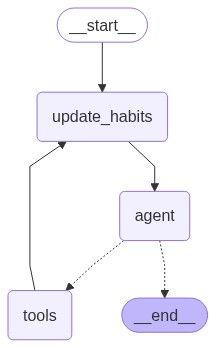

In [56]:
display(Image(app.get_graph().draw_mermaid_png()))

In [57]:
app.invoke({'messages': [HumanMessage(content='hi')]}, config={'configurable': {'thread_id': 'user123'}})

{'messages': [SystemMessage(content="\nYou are an AI habit tracking assistant with advanced reinforcement learning capabilities.\n\nCurrent habits in the system:\n[Habit(id=1, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']), Habit(id=2, name='Read for 30 minutes', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['learning', 'reading']), Habit(id=3, name='Drink 8 glasses of water', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.SATURDAY: 6>}, tags=['health', 'hydration']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']), Habit(id=5, name='Read for 30 minutes', repeat_freque

In [58]:
app.invoke({'messages': [HumanMessage(content='Complete the workout for August 14th 2024')]}, config={'configurable': {'thread_id': 'user123'}})

{'messages': [SystemMessage(content="\nYou are an AI habit tracking assistant with advanced reinforcement learning capabilities.\n\nCurrent habits in the system:\n[Habit(id=1, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']), Habit(id=2, name='Read for 30 minutes', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['learning', 'reading']), Habit(id=3, name='Drink 8 glasses of water', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.SATURDAY: 6>}, tags=['health', 'hydration']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']), Habit(id=5, name='Read for 30 minutes', repeat_freque

In [59]:
state["habits"]

[Habit(id=1, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']),
 Habit(id=2, name='Read for 30 minutes', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['learning', 'reading']),
 Habit(id=3, name='Drink 8 glasses of water', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.SATURDAY: 6>}, tags=['health', 'hydration']),
 Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']),
 Habit(id=5, name='Read for 30 minutes', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['learning', 'reading']),
 

In [60]:
for m in state["messages"]:
    m.pretty_print()

================================ System Message ================================


You are an AI habit tracking assistant with advanced reinforcement learning capabilities.

Current habits in the system:
[Habit(id=1, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']), Habit(id=2, name='Read for 30 minutes', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['learning', 'reading']), Habit(id=3, name='Drink 8 glasses of water', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.SATURDAY: 6>}, tags=['health', 'hydration']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>}, tags=['exercise', 'fitness']), Habit(id=5, 

In [61]:
show_habits_for_date(date(2024, 8, 14))

\nHabits for 2024-08-14:
  Hit the gym (ID: 1): ⏳ Not completed
    Tags: exercise, fitness
  Read for 30 minutes (ID: 2): ⏳ Not completed
    Tags: learning, reading
  Drink 8 glasses of water (ID: 3): ⏳ Not completed
    Tags: health, hydration
  Hit the gym (ID: 4): ⏳ Not completed
    Tags: exercise, fitness
  Read for 30 minutes (ID: 5): ⏳ Not completed
    Tags: learning, reading
  Drink 8 glasses of water (ID: 6): ⏳ Not completed
    Tags: health, hydration
  Hit the gym (ID: 7): ⏳ Not completed
    Tags: exercise, fitness
  Read for 30 minutes (ID: 8): ⏳ Not completed
    Tags: learning, reading
  Drink 8 glasses of water (ID: 9): ⏳ Not completed
    Tags: health, hydration
  Hit the gym (ID: 10): ⏳ Not completed
    Tags: exercise, fitness
  Read for 30 minutes (ID: 11): ⏳ Not completed
    Tags: learning, reading
  Drink 8 glasses of water (ID: 12): ⏳ Not completed
    Tags: health, hydration
